<a href="https://colab.research.google.com/github/ruanvirginio/scriptsMestrado/blob/main/transformaBaseST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando os dados

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

warnings.filterwarnings("ignore")

url_base = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/Medicoes_2018-2024.csv"

df = pd.read_csv(url_base,  sep=',', encoding='latin-1', skiprows=1)

df['Potência Ativa'] = pd.to_numeric(df['Potência Ativa'].str.replace(',', '.'), errors='coerce')
df['Potência Reativa'] = pd.to_numeric(df['Potência Reativa'].str.replace(',', '.'), errors='coerce')

# url_GD = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/EntrantesGD.csv"

url_GD = 'EntrantesGD.csv'

gd = pd.read_csv(url_GD,  sep=';', encoding='latin-1')

gd.rename(columns={
    'Tempo': 'datahora',
}, inplace=True)

## Funções para tratar Outliers

In [2]:
# Função para aplicar o filtro IQR
def filtrar_coluna_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 3.2 * IQR

    return df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]

# Função para aplicar o filtro baseado em Média Móvel
def filtrar_coluna_media_movel(df, coluna, janela=20, threshold=4):

    media_movel = df[coluna].rolling(window=janela, center=True).mean()
    desvio = np.abs(df[coluna] - media_movel)

    limite_superior = media_movel + threshold * desvio.std()
    limite_inferior = media_movel - threshold * desvio.std()

    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Função para aplicar o filtro baseado em Z-Score
def filtrar_coluna_zscore(df, coluna, threshold=3):
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    z_scores = (df[coluna] - media) / desvio_padrao

    return df[np.abs(z_scores) < threshold]

# Função que aplica o filtro escolhido
def aplicar_filtro(df, coluna, metodo='iqr', janela=20, threshold=4, z_threshold=3):
    if metodo == 'iqr':
        return filtrar_coluna_iqr(df, coluna)
    elif metodo == 'media_movel':
        return filtrar_coluna_media_movel(df, coluna, janela=janela, threshold=threshold)
    elif metodo == 'zscore':
        return filtrar_coluna_zscore(df, coluna, threshold=z_threshold)
    else:
        raise ValueError("Método inválido! Escolha entre 'iqr', 'media_movel' ou 'zscore'.")


## Tratamento dos Dados

In [4]:
df.rename(columns={
    'Potência Ativa': 'P',
    'Potência Reativa': 'Q',
    'Data/Hora Medição': 'datahora',
    'Equipamento Medição': 'TRAFO'
}, inplace=True)

df['datahora'] = pd.to_datetime(df['datahora'], format='%d/%m/%Y %H:%M:%S')
gd['datahora'] = pd.to_datetime(gd['datahora'], format='%Y-%m-%d %H:%M:%S')

df = pd.merge(df, gd, on=['datahora', 'TRAFO'])

df['P'] = df['P'].abs()  # salvando o módulo dos valores
df['Q'] = df['Q'].abs()
df['S'] = np.sqrt(df['P']**2 + df['Q']**2)  # Calculando a potência aparente (S), em kVA

# Removendo linhas com S = 0
df = df[df['S'] != 0]

# DataFrame final para armazenar os dados filtrados
df_filtrado = pd.DataFrame()

# Escolha do método de filtragem ('iqr', 'media_movel' ou 'zscore')
metodo_filtro = 'iqr'

# Aplicando o filtro pra limpar os outliers pra cada transformador
for trafo in df['TRAFO'].unique():
    df_trafo = df[df['TRAFO'] == trafo]

    df_trafo_filtrado = aplicar_filtro(df_trafo, 'S', metodo=metodo_filtro, janela=20, threshold=4, z_threshold=3)

    # Adicionar os dados filtrados ao DataFrame final
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)

# Ordenando e removendo duplicatas
df_filtrado = df_filtrado.sort_values(by=['TRAFO', 'datahora'])
df_filtrado = df_filtrado.drop_duplicates(subset=['datahora', 'TRAFO'])

In [5]:
# Lista de transformadores para análise
trafos_escolhidos = [
    # LESTE
    'BSA_DJ_12B1', 'CAA_DJ_12B1',
    'MAA_DJ_12B1',

    # CENTRO
    'ARA_DJ_12B1',
    'BQR_DJ_12B1',
    'RIC_DJ_12B1',

    # OESTE
    'CRM_DJ_12T1', 'PBL_DJ_12B1', 'PTS_DJ_12B1'
]

# Criando gráfico da Potência Aparente ao longo do tempo, separada por TRAFO
# fig_aparente = px.line(df_filtrado, x='datahora', y='S', color='TRAFO',
#                        title='Potência Aparente ao Longo do Tempo por Transformador',
#                        labels={'S': 'Potência Aparente (kVA)', 'Dia': 'Data'})

# Exibir ou salvar o gráfico em
# fig_aparente.show()
# fig_aparente.write_html("Demanda ao longo do tempo - IQR.html")

## Experimentos

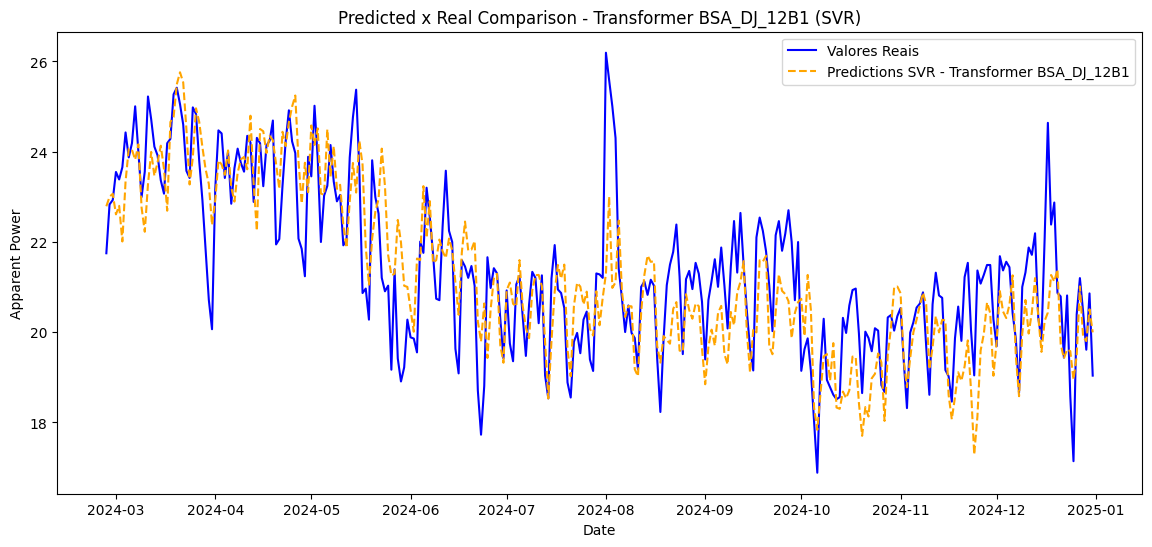

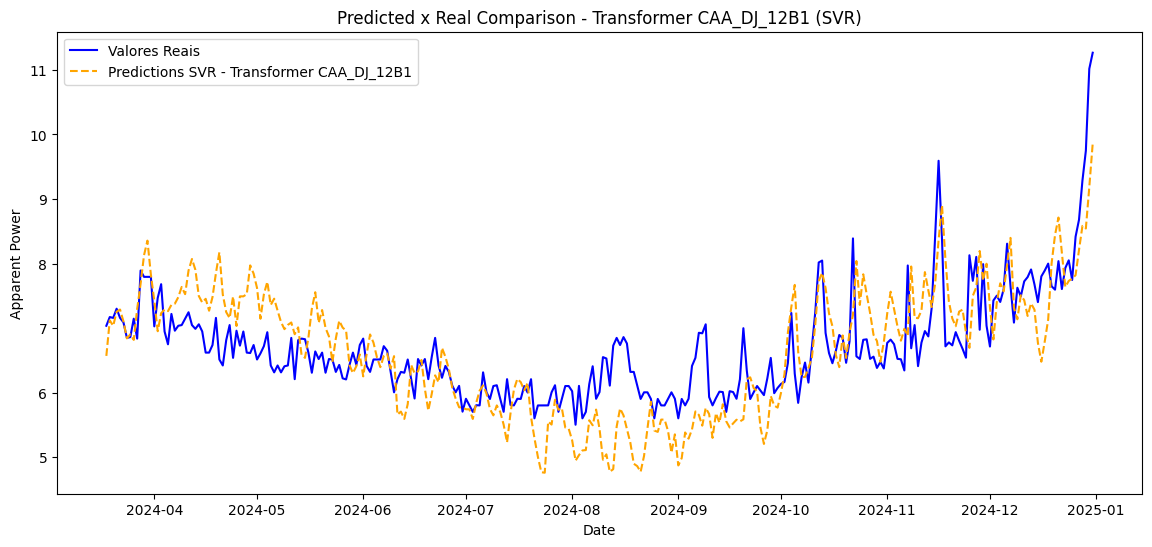

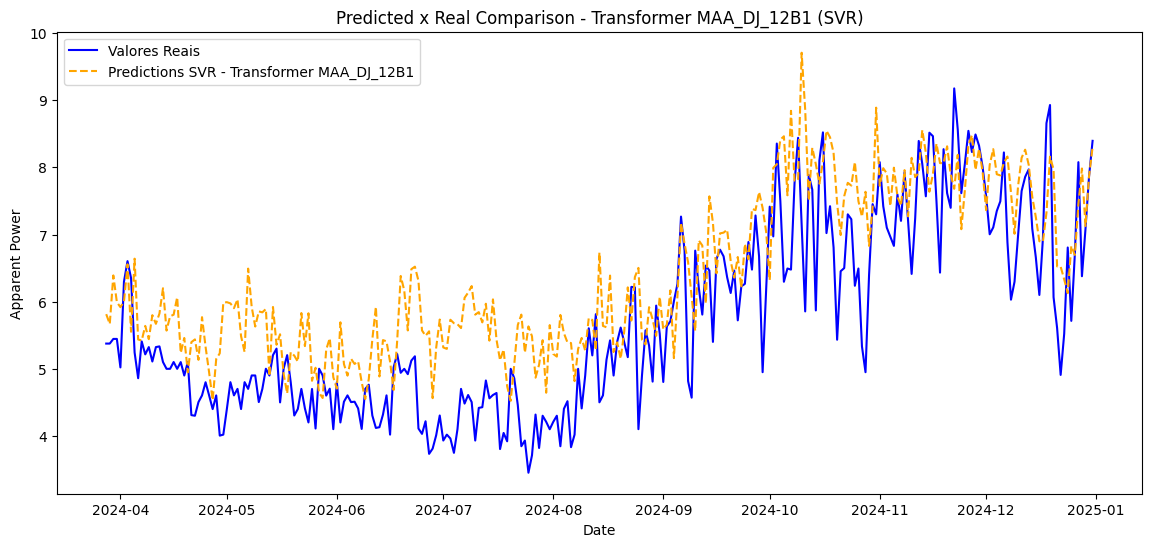

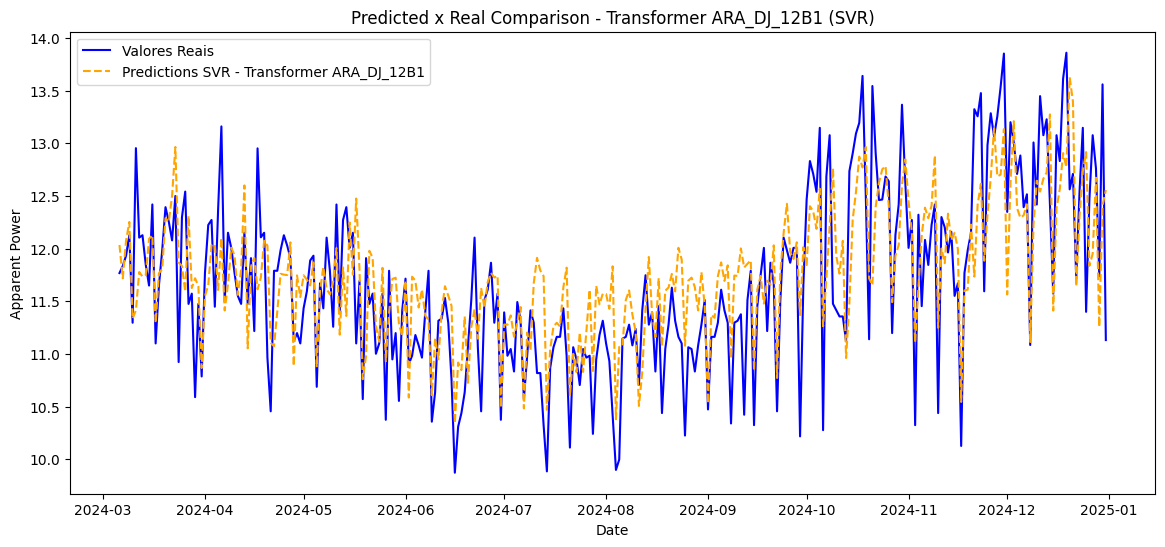

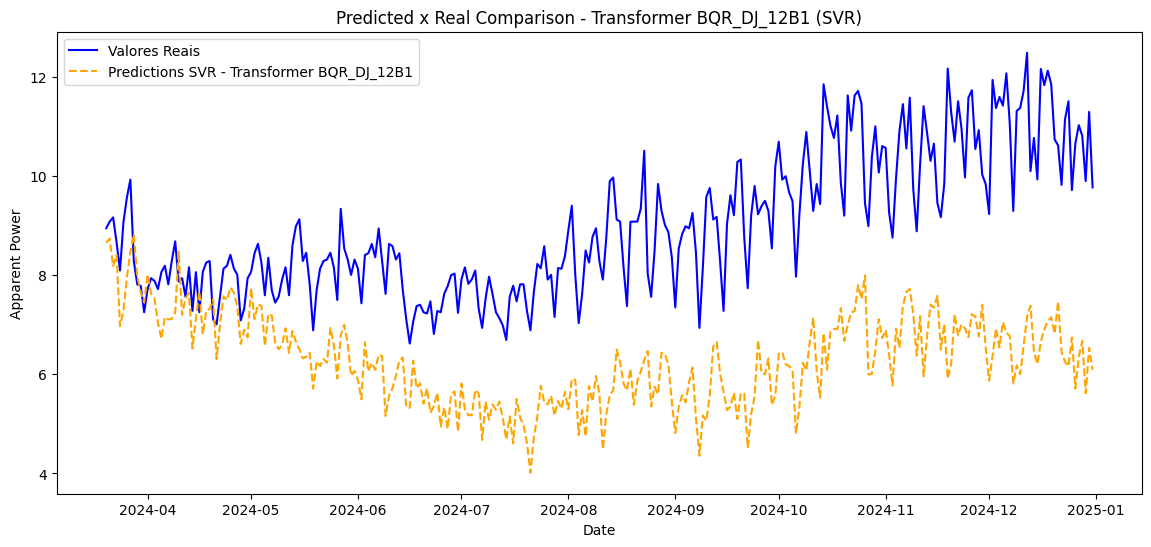

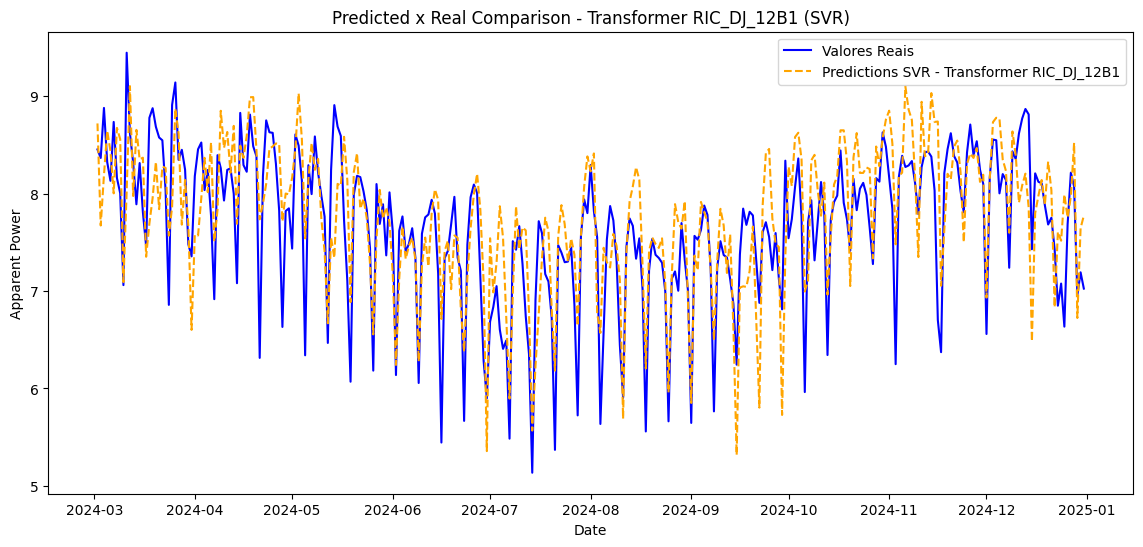

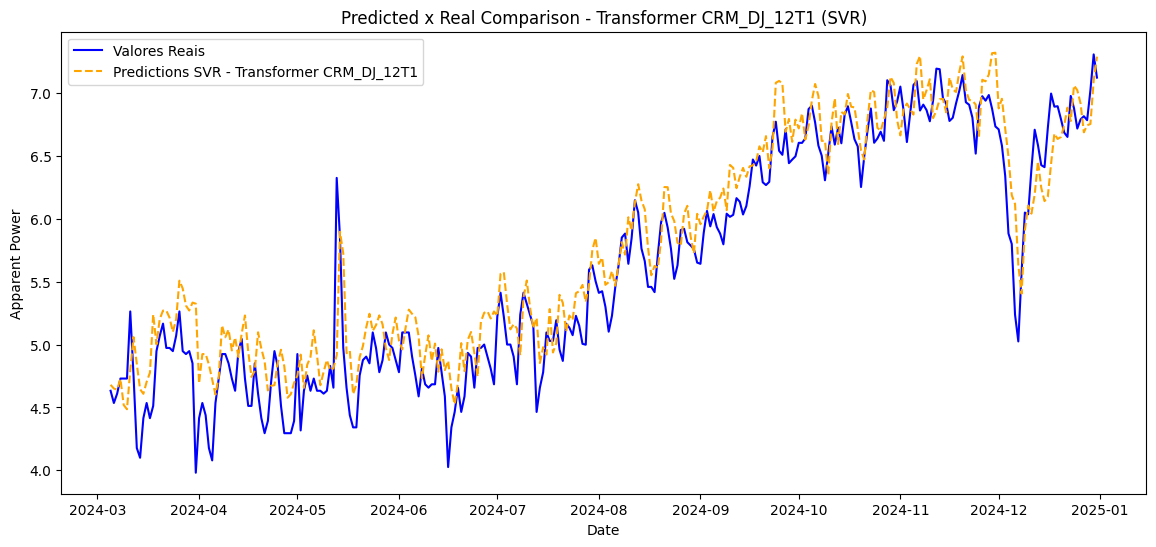

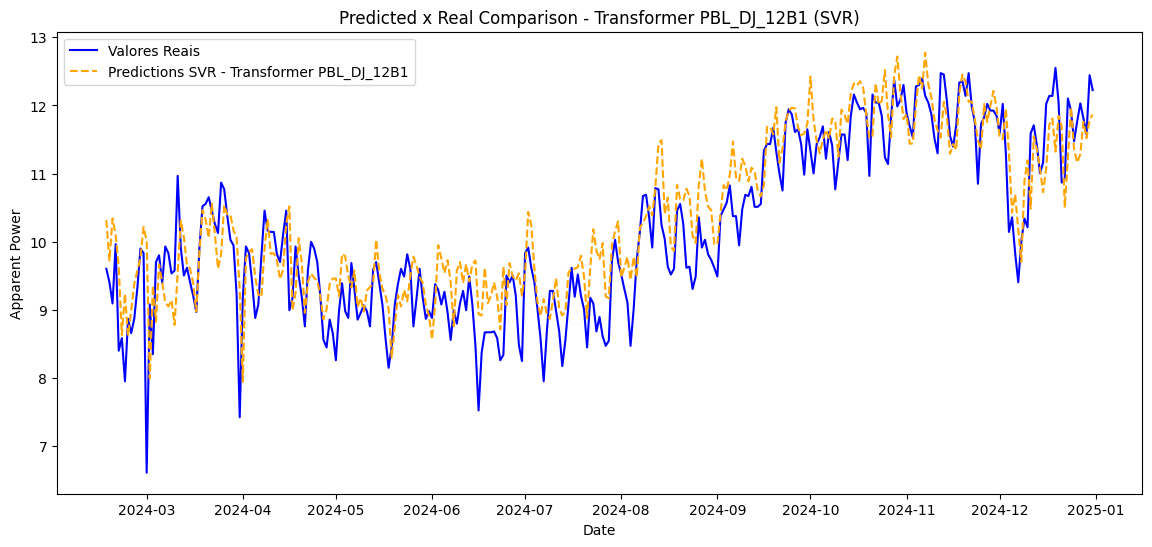

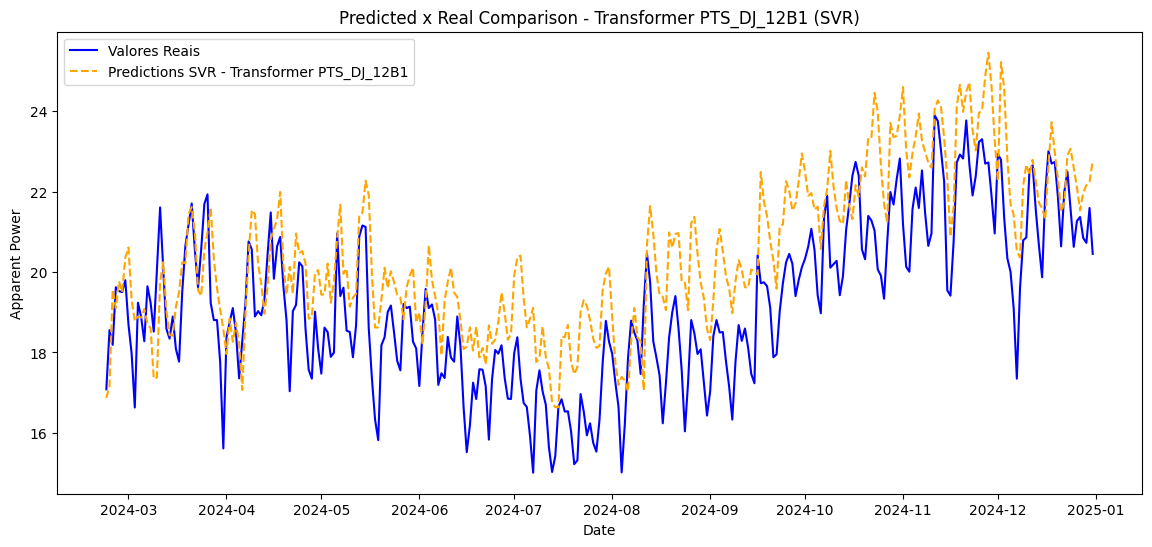

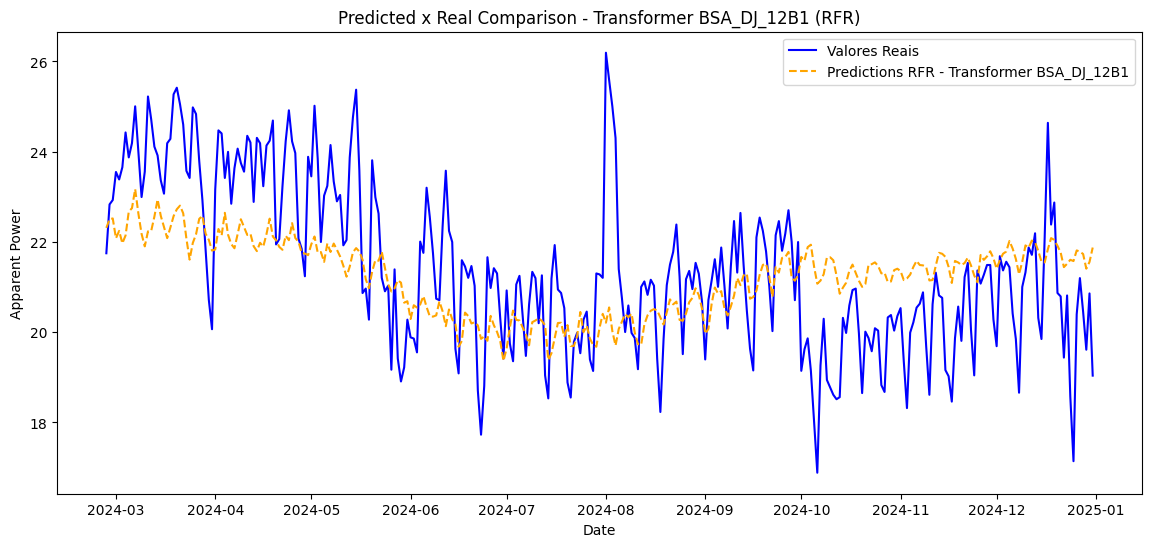

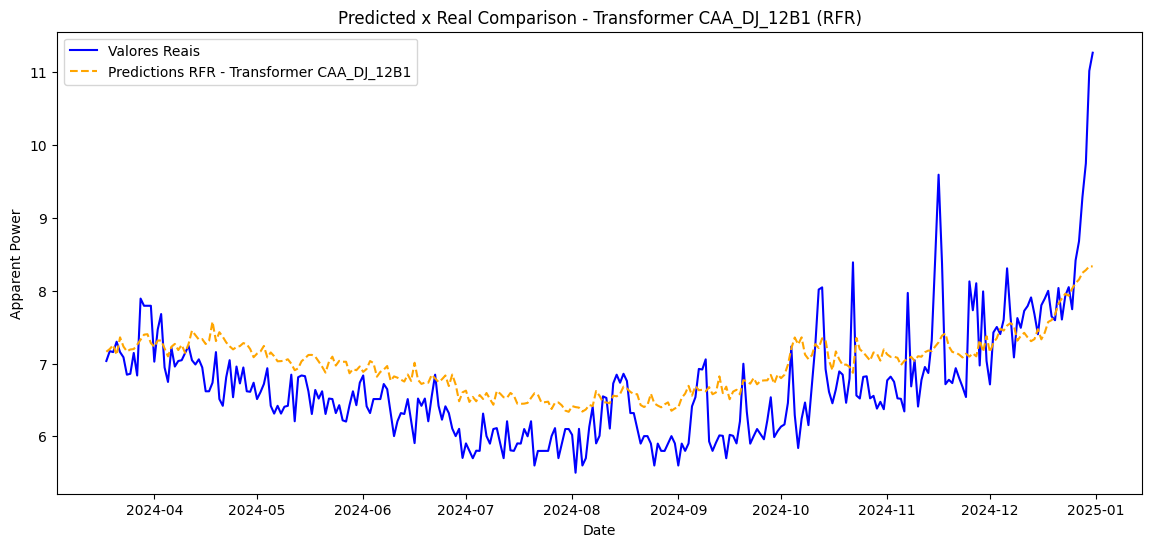

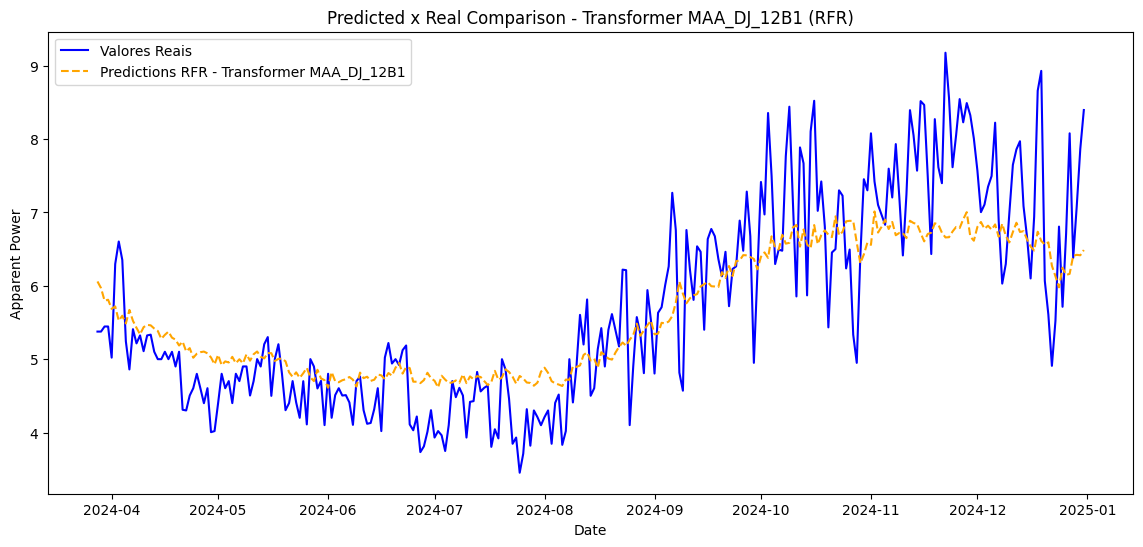

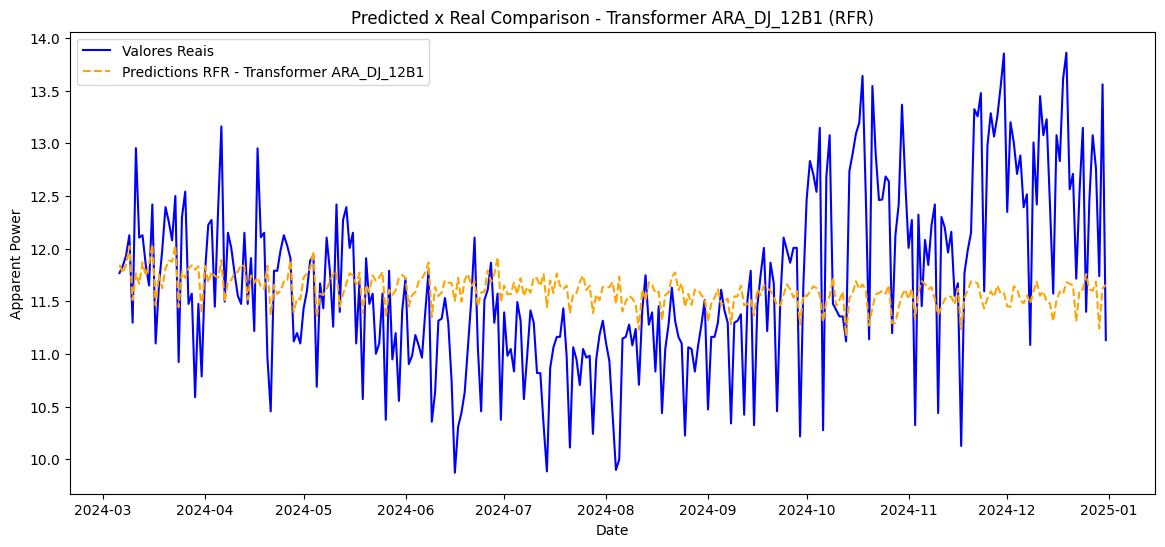

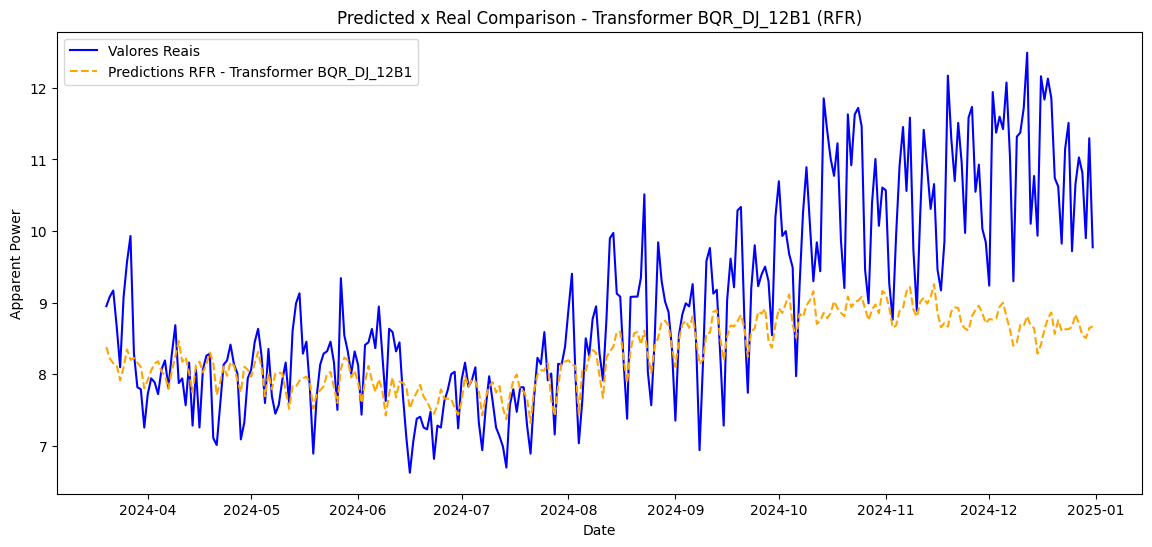

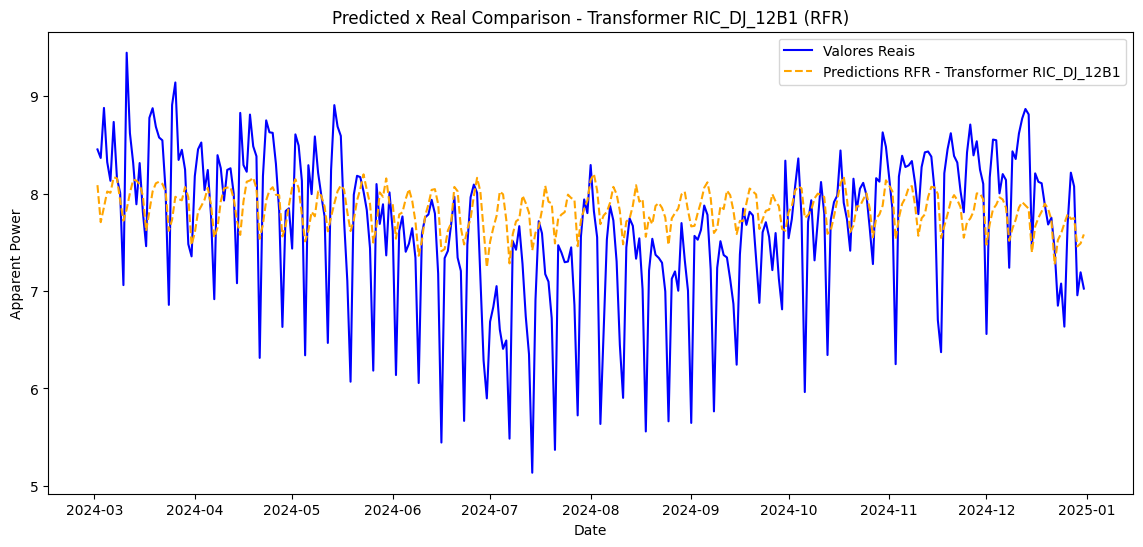

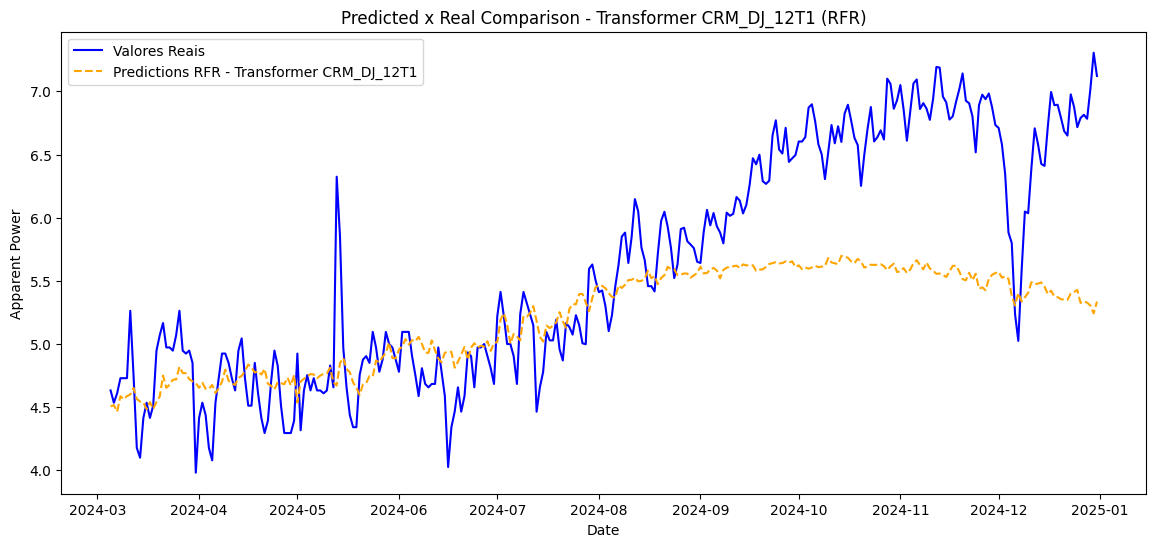

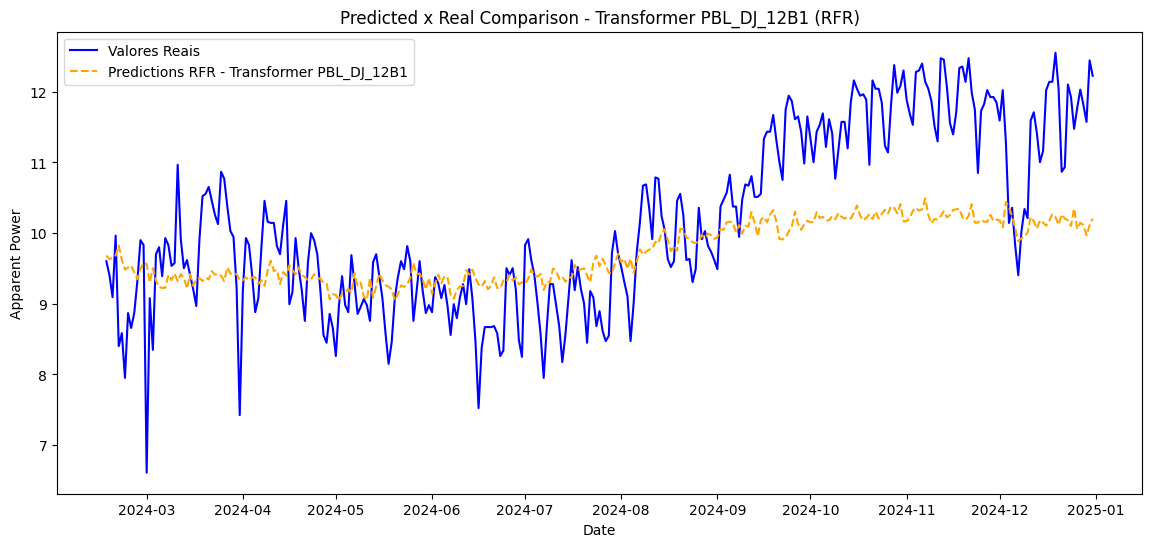

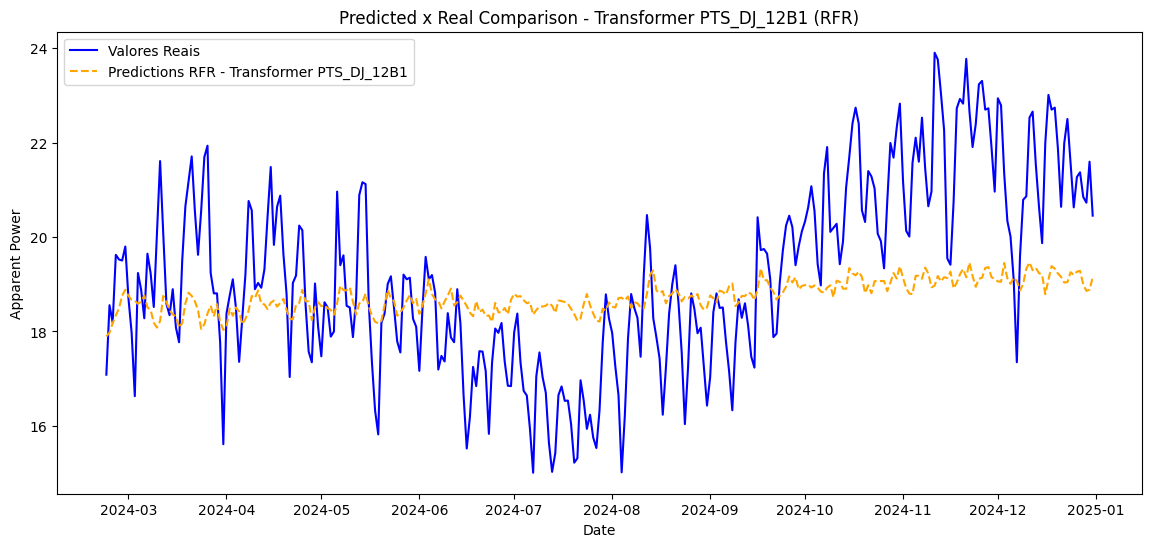

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


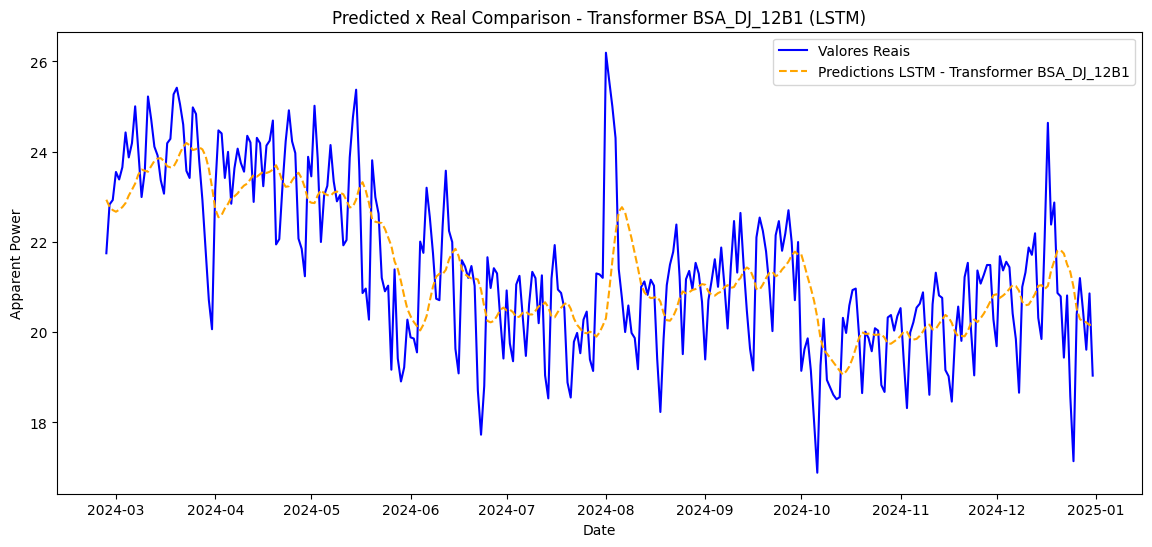

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step


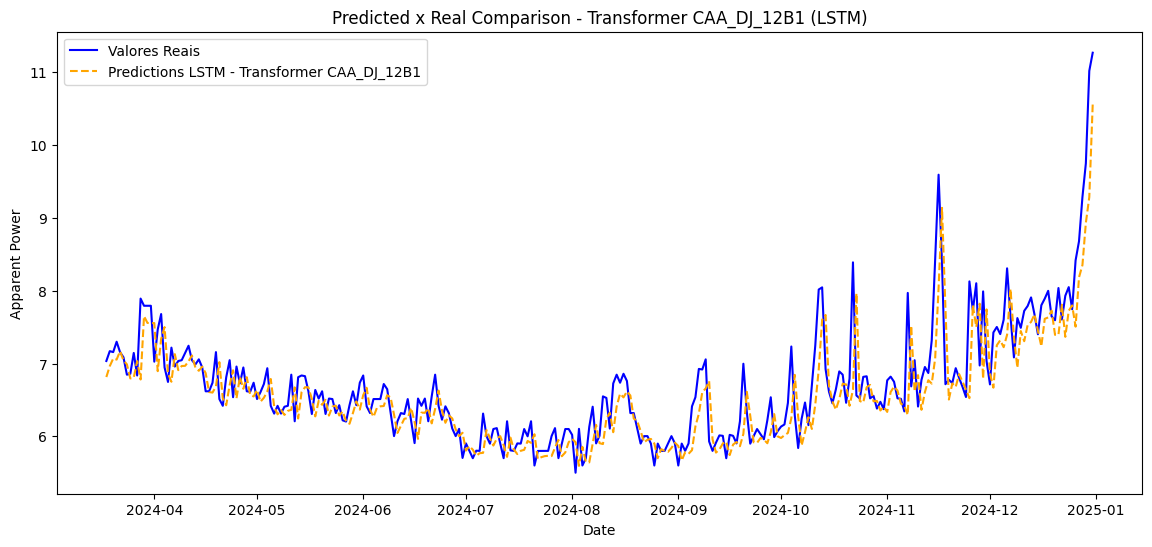

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step


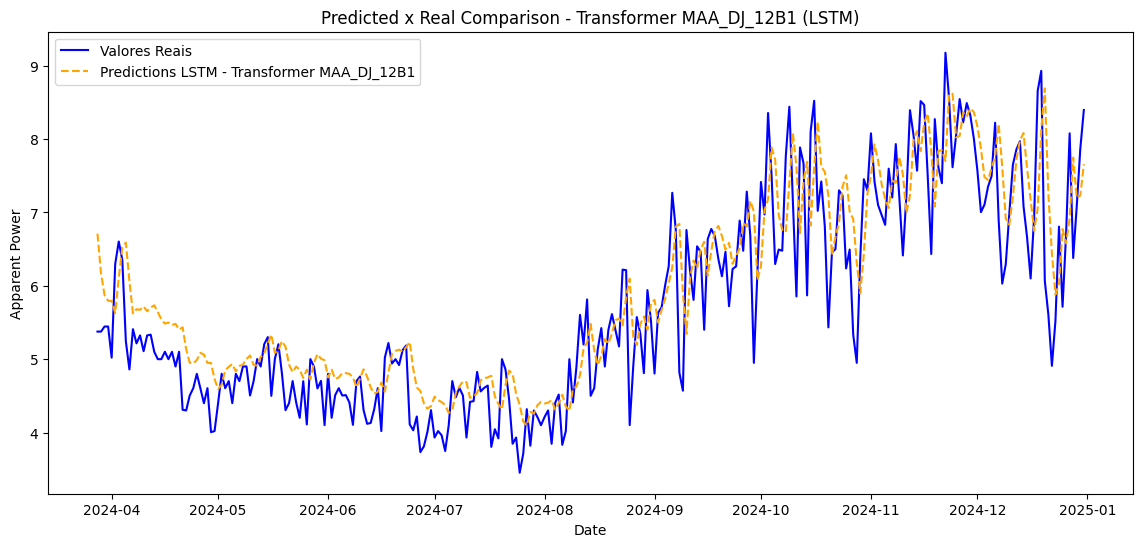

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 612ms/step


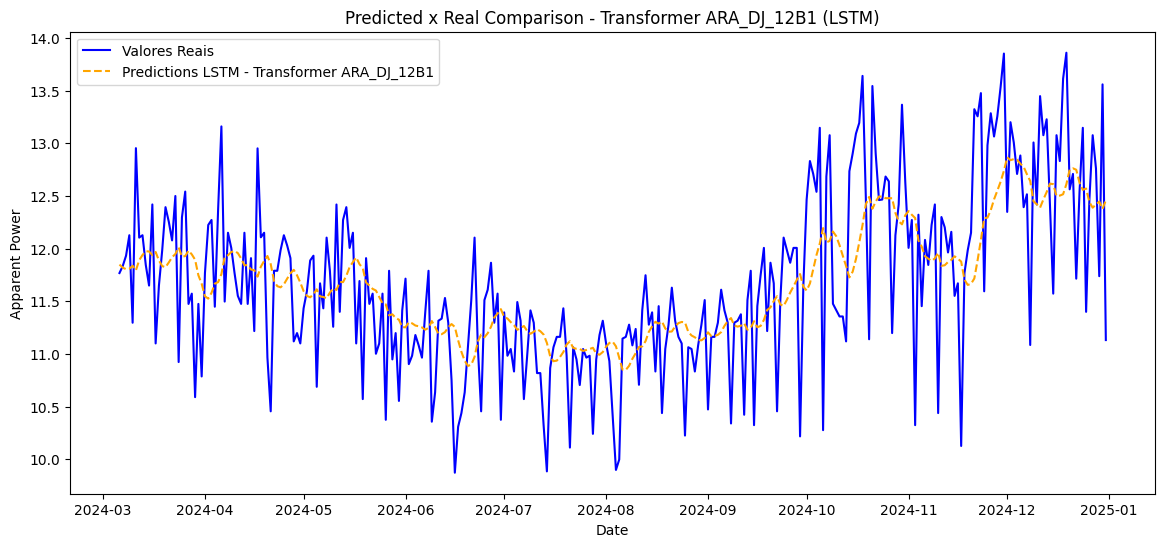

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


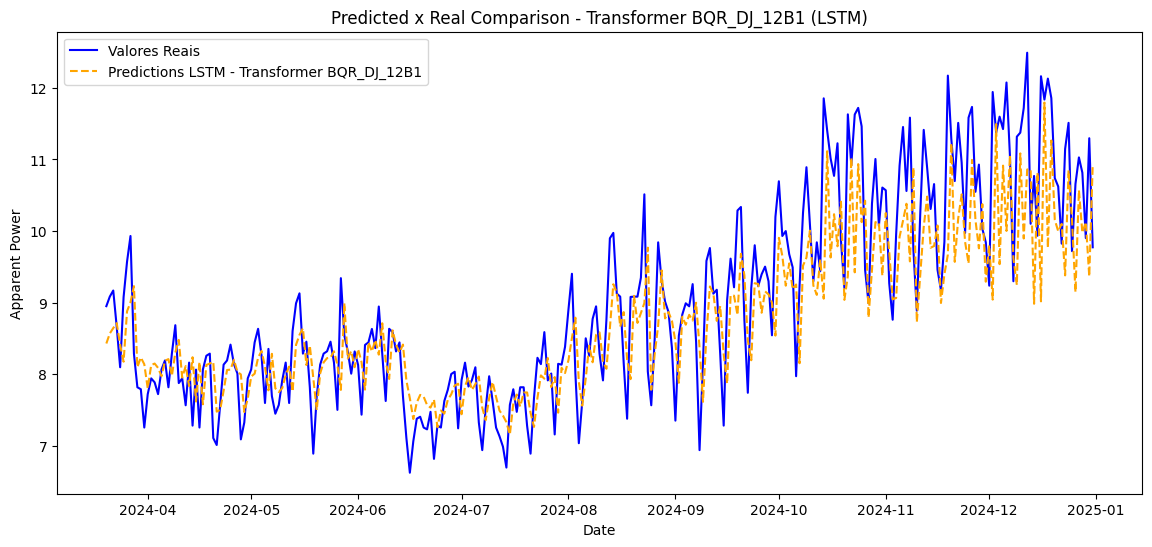

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


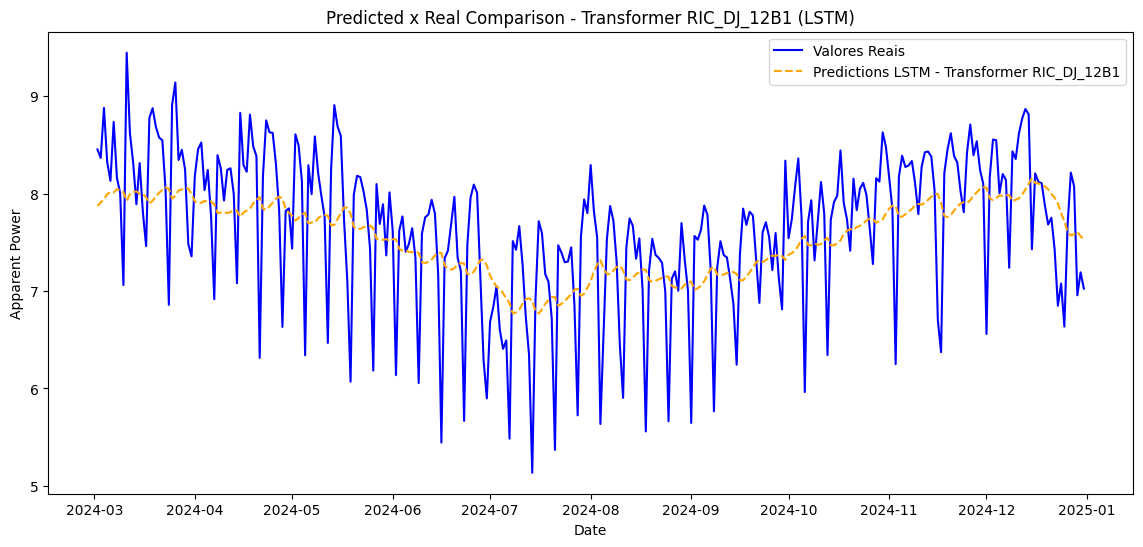

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step


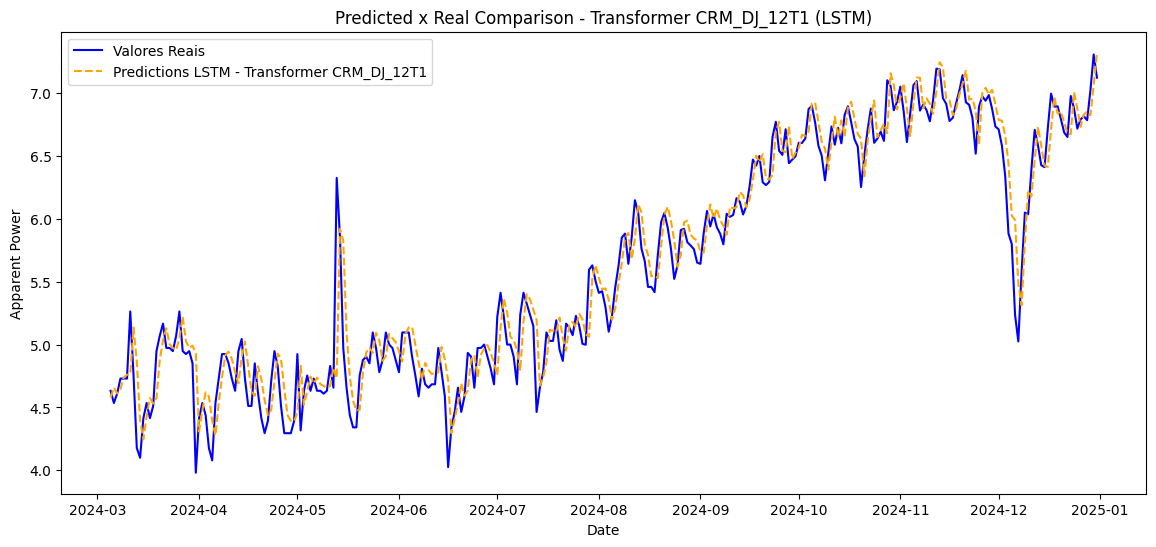

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step


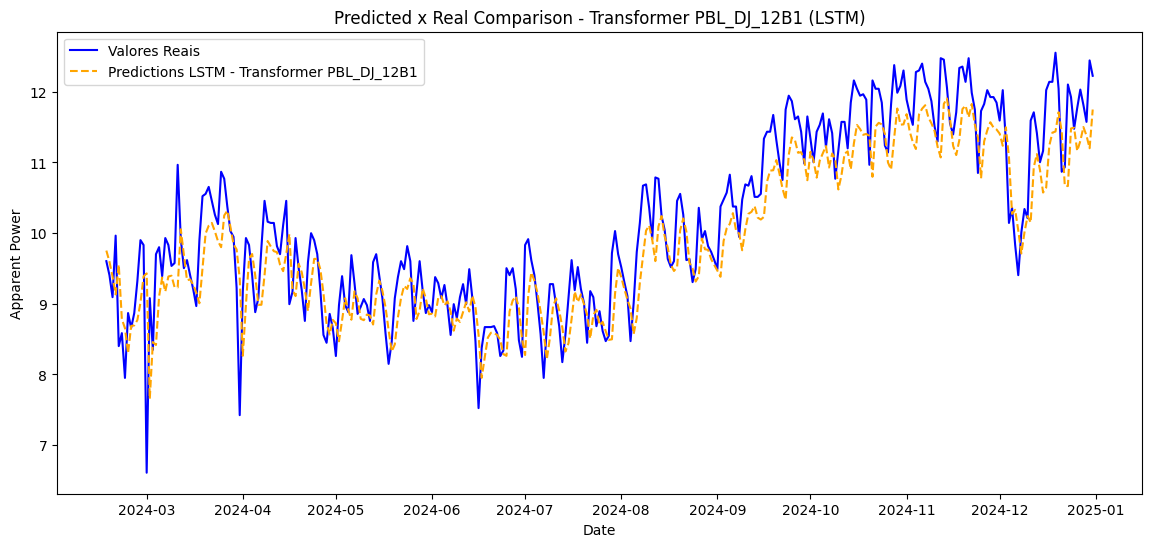

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


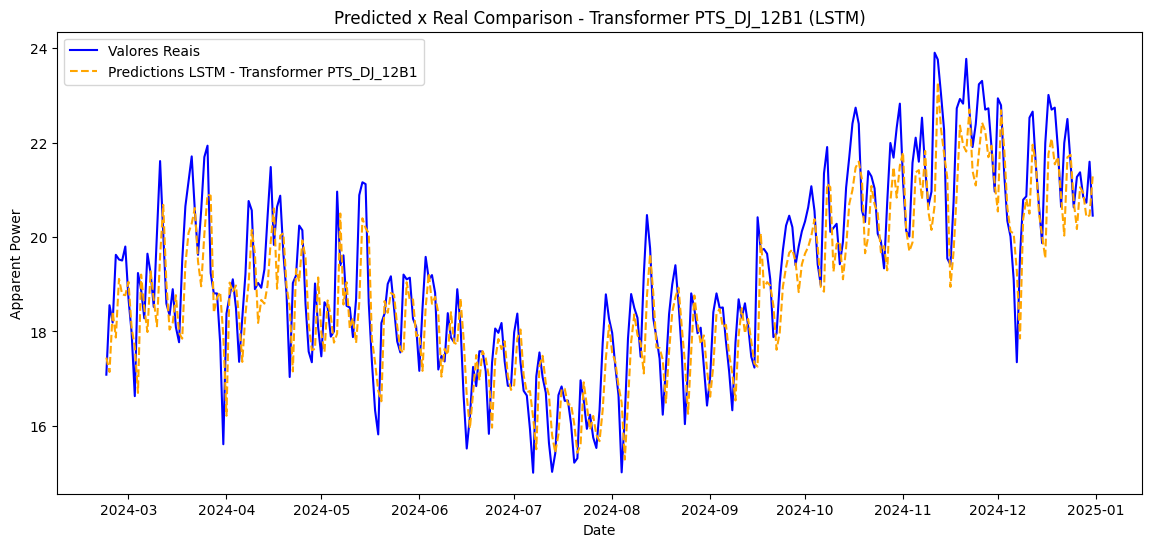

Resultados SVR:
         Trafo Modelo  RMSE  MAE    R2
0  BSA_DJ_12B1    SVR  1.19 0.93  0.58
1  CAA_DJ_12B1    SVR  0.67 0.54  0.30
2  MAA_DJ_12B1    SVR  1.04 0.86  0.42
3  ARA_DJ_12B1    SVR  0.57 0.45  0.55
4  BQR_DJ_12B1    SVR  3.02 2.70 -3.67
5  RIC_DJ_12B1    SVR  0.55 0.44  0.50
6  CRM_DJ_12T1    SVR  0.31 0.25  0.88
7  PBL_DJ_12B1    SVR  0.60 0.46  0.77
8  PTS_DJ_12B1    SVR  1.69 1.44  0.28

Resultados RFR:
         Trafo Modelo  RMSE  MAE   R2
0  BSA_DJ_12B1    RFR  1.61 1.30 0.23
1  CAA_DJ_12B1    RFR  0.61 0.50 0.42
2  MAA_DJ_12B1    RFR  0.77 0.60 0.69
3  ARA_DJ_12B1    RFR  0.82 0.65 0.05
4  BQR_DJ_12B1    RFR  1.24 0.89 0.21
5  RIC_DJ_12B1    RFR  0.71 0.54 0.16
6  CRM_DJ_12T1    RFR  0.75 0.56 0.33
7  PBL_DJ_12B1    RFR  1.03 0.82 0.32
8  PTS_DJ_12B1    RFR  1.85 1.48 0.13

Resultados LSTM:
         Trafo Modelo  RMSE  MAE   R2
0  BSA_DJ_12B1   LSTM  1.32 1.04 0.48
1  CAA_DJ_12B1   LSTM  0.43 0.30 0.71
2  MAA_DJ_12B1   LSTM  0.70 0.54 0.74
3  ARA_DJ_12B1   LSTM  0.64

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo):
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Valores Reais', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Predictions {modelo} - Transformer {trafo}', linestyle='--', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Apparent Power')
    plt.title(f'Predicted x Real Comparison - Transformer {trafo} ({modelo})')
    plt.legend()
    plt.show()

def treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S', 'PotenciaAcumulada']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df = df.interpolate(method='linear')

        dados = df[['S', 'PotenciaAcumulada']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler.fit_transform(dados)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, :])
            y.append(dados_normalizados[i, 0])  # Prevendo apenas "S"

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) if modelo == 'LSTM' else X.reshape(X.shape[0], -1)

        split = int(len(X) * 0.83)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        if modelo == 'SVR':
            regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)

        elif modelo == 'RFR':
            regressor = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=42)
        
        elif modelo == 'LSTM':
            regressor = Sequential()
            regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            regressor.add(LSTM(units=50))
            regressor.add(Dense(1))
            regressor.compile(optimizer='adam', loss='mean_squared_error')
            regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        regressor.fit(X_train, y_train) if modelo != 'LSTM' else None
        y_pred_normalizado = regressor.predict(X_test)
        y_pred = scaler.inverse_transform(np.column_stack((y_pred_normalizado, np.zeros_like(y_pred_normalizado))))[:, 0]
        y_test_inverso = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]

        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test_inverso, y_pred)
        r2 = r2_score(y_test_inverso, y_pred)

        df_previsoes = df.index[split + janela:]
        plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo)

        resultados.append({
            'Trafo': trafo,
            'Modelo': modelo,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
resultados_rfr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
resultados_lstm = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr)
print("\nResultados RFR:")
print(resultados_rfr)
print("\nResultados LSTM:")
print(resultados_lstm)

## Cross-Validation

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo, fold):
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Real values', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Predicted values', linestyle='--', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Apparent Power')
    plt.title(f'Predicted vs Real Comparison - Transformer {trafo} ({modelo})')
    plt.legend()
    plt.grid(True)
    if fold == 5:
        plt.savefig(f"Plot_{trafo}_{modelo}.eps", format="eps", bbox_inches='tight')
    plt.show()

def walk_forward_validation(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df['S'] = df['S'].interpolate(method='linear')

        dados = df[['S']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler.fit_transform(dados)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, 0])
            y.append(dados_normalizados[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1)) if modelo == 'LSTM' else X

        n_splits = 5  # Número de folds para validação walk-forward
        split_size = len(X) // (n_splits + 1)

        for fold in range(n_splits):
            train_size = split_size * (fold + 1)
            X_train, X_test = X[:train_size], X[train_size:train_size + split_size]
            y_train, y_test = y[:train_size], y[train_size:train_size + split_size]

            if modelo == 'SVR':
                regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)
            elif modelo == 'RFR':
                regressor = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, random_state=42)
            elif modelo == 'LSTM':
                regressor = Sequential()
                regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                regressor.add(Dropout(0.2))  # 20% dos neurônios desligados aleatoriamente para evitar overfitting
                regressor.add(LSTM(units=50))
                regressor.add(Dropout(0.2))
                regressor.add(Dense(1))
                regressor.compile(optimizer='adam', loss='mean_squared_error')
                regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

            regressor.fit(X_train, y_train) if modelo != 'LSTM' else None
            y_pred_normalizado = regressor.predict(X_test)
            y_pred = scaler.inverse_transform(y_pred_normalizado.reshape(-1, 1))
            y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

            mse = mean_squared_error(y_test_inverso, y_pred)
            rmse = sqrt(mse)
            mae = mean_absolute_error(y_test_inverso, y_pred)
            r2 = r2_score(y_test_inverso, y_pred)

            df_previsoes = df.index[train_size + janela:train_size + janela + split_size]
            plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo, fold + 1)

            resultados.append({
                'Trafo': trafo,
                'Modelo': modelo,
                'Fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr = walk_forward_validation(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
resultados_rfr = walk_forward_validation(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
# resultados_lstm = walk_forward_validation(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr)
print("\nResultados RFR:")
print(resultados_rfr)
# print("\nResultados LSTM:")
# print(resultados_lstm)
